In [1]:
from ppe.gradient_optimization import optimize_ppe
import jax.numpy as jnp
import jax.scipy.stats as scs
import matplotlib.pyplot as plt

## Example 1: Simple Gaussian model

We assume $ Y \sim \mathcal{N}(\theta, \sigma)$, with $\theta \sim \mathcal{N}(\mu_1, \sigma_1)$. Then, we have the hyperparameter vector $\pmb{\lambda} = [\mu_1, \sigma, \sigma_1]$. Also, for $ A = (a,b] $, we know that 

$$\mathbb{P}_{A|\pmb{\lambda}} = \Phi \Big((b - \mu_1)/\sqrt{\sigma^2 + \sigma_1^2} \Big) - \Phi \Big((a - \mu_1)/\sqrt{\sigma^2 + \sigma_1^2} \Big)$$

### Optimizing $\lambda$ only

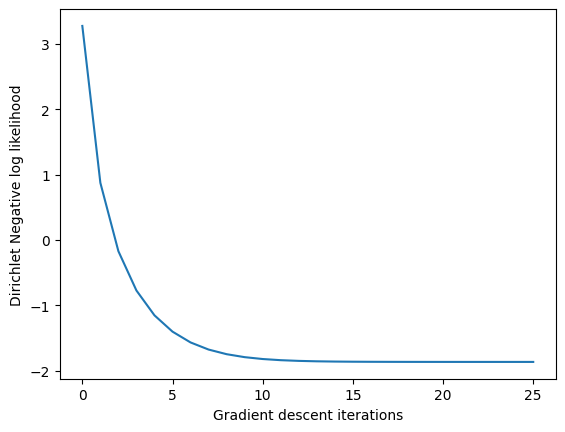

In [2]:
## We define the prior predictive distribution (ppd) for the gaussian model:

def get_gaussian_probs(partition, lam):


    mu_1 = lam[0]
    sigma = lam[1]
    sigma_1 = lam[2]

    p1 = scs.norm.cdf((partition[1] - mu_1)/jnp.sqrt(sigma**2 + sigma_1**2)) - scs.norm.cdf((partition[0] - mu_1)/jnp.sqrt(sigma**2 + sigma_1**2))

    return p1


### The lower and upper partitions should be wide enough so that the probabilities sum to 1!

"""

partitions = [np.array([[-1000,-2], [-2, 3], [3, 1000]])]

expert_probs = [np.array([0.2, 0.7, 0.1])]

J = 1

"""


partitions = [jnp.array([[-1000,-2], [-2, 3], [3, 1000]]),
              jnp.array([[-1000,-1], [-1, 1000]])]

expert_probs = [jnp.array([0.2, 0.7, 0.1]),
                jnp.array([0.7, 0.3])]

J = 2


opt_class = optimize_ppe(alpha=6, J=J, ppd=get_gaussian_probs)




lam_new, lik_progression, grad_progression = opt_class.gradient_descent(partitions, expert_probs, lam_0=jnp.ones(3)*2, iters = 500, step_size=0.2, tol = 1e-5)



plt.plot(lik_progression)
plt.xlabel("Gradient descent iterations")
plt.ylabel("Dirichlet Negative log likelihood")
plt.show()

In [3]:
lam_new

Array([-0.8748227,  2.2349665,  2.2349665], dtype=float32)

In [4]:
opt_class.get_alpha(partitions, lam_new, expert_probs)

Array(8.496458, dtype=float32)

In [5]:
[opt_class.ppd_function(partition, lam_new) for partition in partitions]

[Array([0.36092487, 0.52896273, 0.11011243], dtype=float32),
 Array([0.4842044, 0.5157956], dtype=float32)]

In [6]:
expert_probs

[Array([0.2, 0.7, 0.1], dtype=float32), Array([0.7, 0.3], dtype=float32)]

### Optimizing both $\alpha$ and $\lambda$

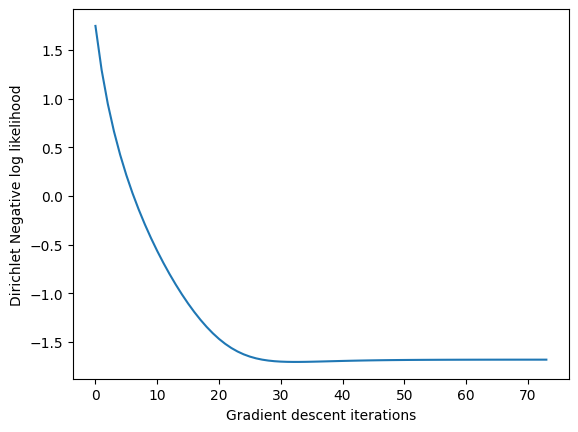

In [7]:

partitions = [jnp.array([[-1000,-2], [-2, 3], [3, 1000]]),
              jnp.array([[-1000,-1], [-1, 1000]])]

expert_probs = [jnp.array([0.2, 0.7, 0.1]),
                jnp.array([0.7, 0.3])]

J = 2

opt_class = optimize_ppe(alpha=None, J = 2, ppd=get_gaussian_probs)


lam_new, lik_progression, grad_progression = opt_class.gradient_descent(partitions, expert_probs, lam_0=jnp.ones(3)*2, iters = 1000, step_size=0.1, tol = 1e-5)

plt.plot(lik_progression)
plt.xlabel("Gradient descent iterations")
plt.ylabel("Dirichlet Negative log likelihood")
plt.show()

In [8]:
lam_new

Array([-0.34123656,  1.9267907 ,  1.9267907 ], dtype=float32)

In [9]:
opt_class.get_alpha(partitions, lam_new, expert_probs)

Array(7.3774786, dtype=float32)

## Second example: binary classification in the presence of covariates (taken from the paper)

We consider a generative model for binary data in the presence of a vector of covariates. The observable variable conditioned on the parameters is distributed according to a Bernoulli model and we take a multivariate Gaussian distribution as the prior distribution for the vector of parameters in the predictor function. This can be formalized as:

$$ y|\pmb{\theta} \sim \pmb{\mathcal{B}(\Phi (\pmb{x}^{\text{T}}\pmb{\theta}))}, $$

where

$$\pmb{\theta} \sim \mathcal{N}_D(\mu, \Sigma).$$

This gives us

$$ y \sim \mathcal{B}(p(\pmb{x}, \pmb{\lambda})),$$

where 

$$ p(\pmb{x}, \pmb{\lambda}) = \Phi \Big(\frac{\pmb{x}^{\text{T}}\pmb{\mu}}{\sqrt{1 + \pmb{x}^{\text{T}}\Sigma\pmb{x}}}\Big).$$

Our hyperparameter set is defined as $\pmb{\lambda} = [\mu, \Sigma]$. Since we have binary classification, there are only two partitions, ${0,1}$. If we define $A_1 = \{0\}$ and $A_2 = \{1\}$ we get:

$$\mathbb{P}_{A_1 | \pmb{\lambda}} = 1 -  p(\pmb{x}, \pmb{\lambda}) \text{ and } \mathbb{P}_{A_2 | \pmb{\lambda}} = p(\pmb{x}, \pmb{\lambda}).$$

For this example we assume $N=5$ and that the variables are independent with one another, meaning that $\Sigma$ is a diagonal matrix.

### Optimizing $\lambda$ only

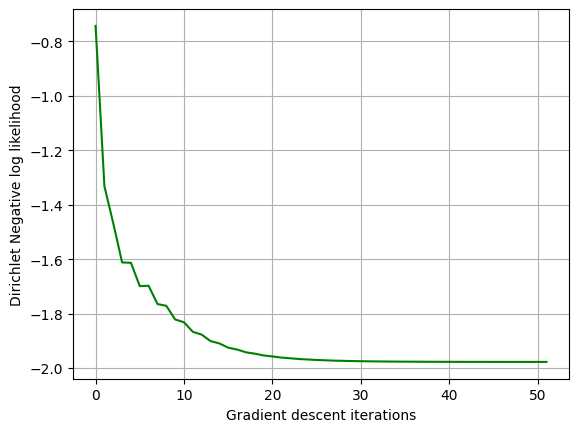

In [10]:
def get_bernoulli_probs(partition, lam, covariate_set):

    nom = jnp.inner(jnp.array(lam[:5]), covariate_set)
    den = jnp.sqrt(1 + covariate_set.T@jnp.diag(jnp.array(lam[5:]))@covariate_set)

    p1 = 1 - scs.norm.cdf(nom / den)

    if partition == 0:
        return p1

    return 1 - p1




### The lower and upper partitions should be wide enough so that the probabilities sum to 1

partitions = [jnp.array([0,1]),
              jnp.array([0,1]),
              jnp.array([0,1])]

expert_probs = [jnp.array([0.35, 0.65]),
                jnp.array([0.3, 0.7]),
                jnp.array([0.2, 0.8])]

total_covariate_sets = [jnp.array([1.3, 0.7, 0.5, -0.7, -0.5]),
                        jnp.array([1, 0.5, 0.4, -0.8, 0]),
                        jnp.array([0.3, 0.7, 2, -2, 0.2])]

J = 3

opt_class = optimize_ppe(alpha=5, J = J, ppd=get_bernoulli_probs)




lam_new, lik_progression, grad_progression = opt_class.gradient_descent(partitions, expert_probs, lam_0=jnp.ones(10)*2.0, iters = 1000, step_size=0.5, tol = 1e-5, total_covariates=total_covariate_sets)


plt.plot(lik_progression, color="Green", linewidth=1.5)
plt.xlabel("Gradient descent iterations")
plt.ylabel("Dirichlet Negative log likelihood")
plt.grid(True)
plt.savefig("BernoulliEx2GdLik.pdf", format="pdf", bbox_inches="tight")
plt.show()

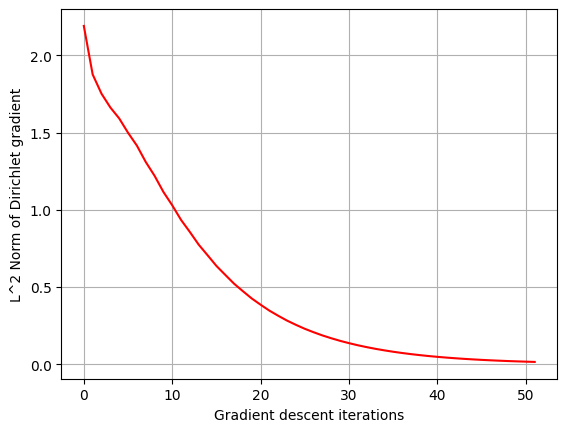

In [11]:
plt.plot(grad_progression, color="Red", linewidth=1.5)
plt.xlabel("Gradient descent iterations")
plt.ylabel("L^2 Norm of Dirichlet gradient")
plt.grid(True)
plt.savefig("BernoulliEx2GdL2Grad.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [12]:
lam_new

Array([0.7607553, 1.6530342, 2.5012453, 1.9487813, 2.275448 , 2.454794 ,
       2.1239815, 2.082523 , 2.22601  , 2.0328102], dtype=float32)

In [13]:
opt_class.get_alpha(partitions, lam_new, expert_probs, total_covariate_sets)

Array(119.007126, dtype=float32)

In [14]:
[jnp.array(opt_class.ppd_function(partitions[j], lam_new, total_covariate_sets[j])) for j in range(J)]

[Array([0.3781122, 0.6218878], dtype=float32),
 Array([0.33386922, 0.6661308 ], dtype=float32),
 Array([0.25280803, 0.74719197], dtype=float32)]

### Optimizing both $\alpha$ and $\lambda$

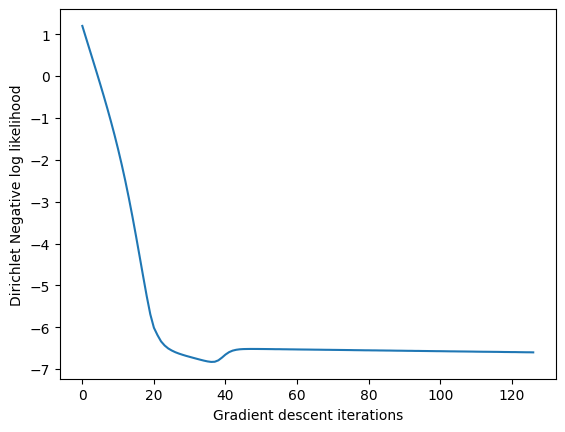

In [16]:
def get_bernoulli_probs(partition, lam, covariate_set):

    nom = jnp.inner(jnp.array(lam[:3]), covariate_set)
    den = jnp.sqrt(1 + covariate_set.T@jnp.diag(jnp.array(lam[3:]))@covariate_set)

    p1 = 1 - scs.norm.cdf(nom / den)

    if partition == 0:
        return p1

    return 1 - p1




### The lower and upper partitions should be wide enough so that the probabilities sum to 1

partitions = [jnp.array([0,1]),
              jnp.array([0,1]),
              jnp.array([0,1])]

expert_probs = [jnp.array([0.35, 0.65]),
                jnp.array([0.3, 0.7]),
                jnp.array([0.2, 0.8])]

total_covariate_sets = [jnp.array([1.3, 0.7, 0.5]),
                        jnp.array([1, 0.5, 0.4]),
                        jnp.array([0.3, 0.7, 2])]



opt_class = optimize_ppe(alpha=None, J = J, ppd=get_bernoulli_probs)
lam_new, lik_progression, grad_progression = opt_class.gradient_descent(partitions, expert_probs, lam_0=jnp.ones(6), iters = 1000, step_size=0.01, tol = 1e-6, total_covariates=total_covariate_sets)


plt.plot(lik_progression)
plt.xlabel("Gradient descent iterations")
plt.ylabel("Dirichlet Negative log likelihood")
plt.show()

In [17]:
lam_new

Array([0.13414429, 0.35668647, 0.8644017 , 1.3587406 , 1.1267419 ,
       1.0287751 ], dtype=float32)

In [18]:
opt_class.get_alpha(partitions, lam_new, expert_probs, total_covariate_sets) ## resulting alpha from the MLE closed form solution for the optimized hyperparameters lambda

Array(269.4433, dtype=float32)

In [19]:
best_model_probs = [jnp.array(opt_class.ppd_function(partitions[j], lam_new, total_covariate_sets[j])) for j in range(len(expert_probs))]

In [20]:
best_model_probs

[Array([0.33629572, 0.6637043 ], dtype=float32),
 Array([0.34715027, 0.65284973], dtype=float32),
 Array([0.20073712, 0.7992629 ], dtype=float32)]